In [29]:
import numpy as np
import pandas as pd
import os, subprocess, shutil
import matplotlib.pyplot as plt
import pyvista as pv
from myusefultools.parser import getVTKList


REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()

plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

caseName   = "constantHead"
solverFoam = "RichardsFoam"
# names = ["U"]
# probeVars  = " ".join(names)

PATH_TO_VTK = f"{caseName}/VTK"

## Check that solver is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")


In [30]:
def getMeanU(h:np.float64) -> tuple[np.float64, np.float64]:

    ## Bring template for probes
    subprocess.run(f"cp {REPO_PATH}/misc/h.tpl {caseName}/0.000/h".split())

    ## Replace placeholders in template
    subprocess.run(["sed", "-i", f"s/<<h_VALUE>>/{h:.3E}/g", f"{caseName}/0.000/h"])

    ## Clean previous runs
    subprocess.run([f"foamListTimes", "-rm"], cwd=f"./{caseName}")

    ## Clean postprocessing
    postProc_path = f"{caseName}/postProcessing"
    if os.path.exists(postProc_path): shutil.rmtree(postProc_path)

    ## Run case
    subprocess.run([solverFoam], cwd=f"./{caseName}", stdout=subprocess.DEVNULL)

    ## Convert to VTK
    subprocess.run(["foamToVTK", "-noZero"], cwd=f"./{caseName}", stdout=subprocess.DEVNULL)

    ## Extract VTK result (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    last_vtk = all_vtk_paths[-1]

    mesh = pv.read(last_vtk)

    U = mesh['U']
    Uz = U[:,-1]
    meanU = np.average(Uz)
    #stdU = np.std(Uz)

    return meanU #(meanU, stdU)

In [31]:
#harr = np.linspace(-0.700,0.000,24)
harr = [-0.429]
qin = [getMeanU(h) for h in harr]

In [32]:
# # To run using multiprocessing (lol they all access the same)
# from multiprocessing import Pool
# with Pool() as pool:
#     qin = pool.map(getMeanU,harr)

In [33]:
postProc_path = f"{caseName}/postProcessing"
postProc_clean = f"{caseName}/postProcessingClean"
if os.path.exists(postProc_clean): shutil.rmtree(postProc_clean)
shutil.copytree(postProc_path, postProc_clean)

'constantHead/postProcessingClean'

In [34]:
location_probes = f"{postProc_clean}/probes/0.000"

for file in os.listdir(location_probes):
    subprocess.run(["sed", "-i", r"s/\s\s\+/\t/g", file], cwd=location_probes)
    subprocess.run(["sed", "-i", r"s/^\t//g", file], cwd=location_probes)
    subprocess.run(["sed", "-i", r"/^#/d", file], cwd=location_probes)

In [38]:
probe = "theta"
results = pd.read_csv(os.path.join(location_probes,probe), sep="\t", names=["Time (s)"] + [f"θ{i}" for i in range(12)], index_col="Time (s)")
results.tail()

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9,θ10,θ11
Time (s),,,,,,,,,,,,
354293.0,0.110444,0.110445,0.110444,0.110437,0.110429,0.110443,0.110477,0.110489,0.110443,0.110350,0.110318,0.110341
355611.0,0.110444,0.110445,0.110447,0.110445,0.110432,0.110423,0.110444,0.110500,0.110525,0.110474,0.110399,0.110355
357062.0,0.110443,0.110444,0.110447,0.110450,0.110444,0.110422,0.110406,0.110439,0.110506,0.110570,0.110557,0.110512
358657.0,0.110443,0.110442,0.110443,0.110449,0.110456,0.110443,0.110405,0.110366,0.110385,0.110481,0.110552,0.110574
360411.0,0.110444,0.110443,0.110442,0.110445,0.110460,0.110473,0.110458,0.110386,0.110317,0.110300,0.110352,0.110411


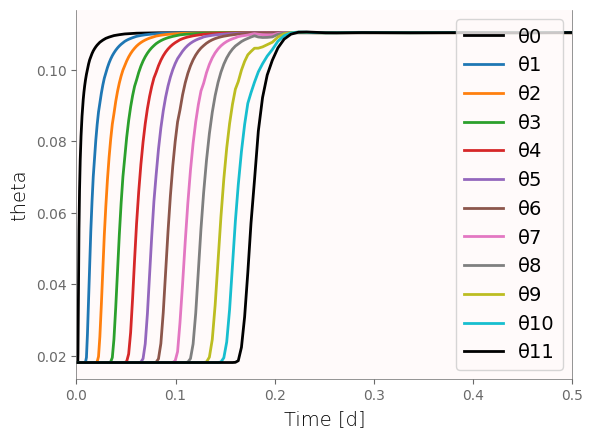

In [37]:

fig,ax = plt.subplots()
for i in range(12):
    ax.plot(results.index/86400, results[f'θ{i}'], label = f'θ{i}')
ax.legend()
ax.set_xlabel("Time [d]")
ax.set_ylabel(probe)
ax.set_xlim(0, 0.5)
plt.show()